In [1]:
import tensorflow as tf
import tensorflowjs as tfjs
from maml import MAML
from tasks import SinusoidRegressionTaskDistribution
import numpy as np
import matplotlib.pyplot as plt


#is gpu available?
print("GPU Available: ", tf.test.is_gpu_available())

2024-12-14 18:07:59.314542: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-14 18:07:59.729515: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734196079.881814    2380 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734196079.921316    2380 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-14 18:08:00.253977: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True


I0000 00:00:1734196098.558448    2380 gpu_device.cc:2022] Created device /device:GPU:0 with 5582 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [2]:

ann = tf.keras.models.Sequential([
    tf.keras.layers.Dense(40, activation='relu', input_shape=(1,)),
    tf.keras.layers.Dense(40, activation='relu'),
    tf.keras.layers.Dense(1)
])

taskDistribution = SinusoidRegressionTaskDistribution()
maml = MAML(ann, taskDistribution)

# Trains a batch of 1000 iterations with 10 task samples each, distributed over 25 tasks
maml.trainBatch(nSamples = 10, nTasks = 25, nBatch = 1000)



/home/kristmro/workspace/MetaLearningCodes/TestingSin/venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1734196377.924798    2380 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5582 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


AttributeError: in user code:

    File "/home/kristmro/workspace/MetaLearningCodes/TestingSin/ground/model.py", line 37, in None  *
        lambda batch: self.update(
    File "/home/kristmro/workspace/MetaLearningCodes/TestingSin/ground/maml.py", line 38, in update  *
        loss = tf.reduce_sum(
    File "/home/kristmro/workspace/MetaLearningCodes/TestingSin/ground/maml.py", line 21, in taskLoss
        loss = self.lossfn(y_train, self.model(

    AttributeError: 'TfMethodTarget' object has no attribute 'lossfn'


In [ ]:
#Save model
maml.saveKeras('/home/kristmro/workspace/MetaLearningCodes/TestingSin/savedModels/maml')

NameError: name 'maml' is not defined

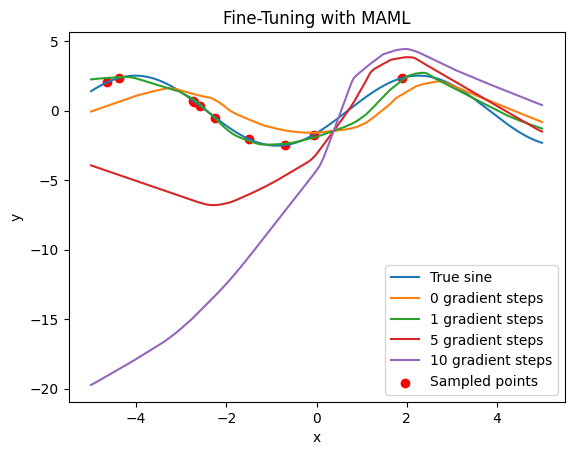

In [6]:

# Initialize task distribution and MAML model
taskDistribution = SinusoidRegressionTaskDistribution()
task = taskDistribution.sampleTask()

# Generate data for the task
ys, xs = task.sampleFromTask(10, -5, 5)

# Fine-tune and visualize results
x = tf.reshape(tf.linspace(-5., 5., 1000), (1000, 1))
plt.plot(x, task(x), label="True sine")

# Perform multiple gradient steps for fine-tuning
for nSteps in [0, 1, 5, 10]:
    updated_weights = maml.model.trainable_weights
    for step in range(nSteps):
        with tf.GradientTape() as tape:
            loss = maml.lossfn(ys, maml.model(tf.reshape(xs, (-1, 1))))
        grads = tape.gradient(loss, maml.model.trainable_weights)
        updated_weights = maml.fastWeights.computeUpdate(zip(grads, updated_weights))

    predictions = maml.fastWeights(updated_weights, x)
    plt.plot(x, predictions, label=f'{nSteps} gradient steps')

# Plot the training points
plt.scatter(xs, ys, color='red', label='Sampled points')
plt.title('Fine-Tuning with MAML')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
